<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch8-Integrated_Planning_Learning/Dyna_Qplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
%matplotlib inline

# Integrated Planning, Acting and Learning using DYNA-Q

## Dyna Maze

In [ ]:
VALID = 0
START = 1
PATH = 2
FINISH = 3
OBSTACLE = 4

def get_maze():
  nRows = 6
  nCols = 9
  map = np.zeros((nRows,nCols),dtype=np.int8)
  map[2,0] = START
  map[0,8] = FINISH
  map[1:4,2] = OBSTACLE
  map[4,5] = OBSTACLE
  map[0:3,7] = OBSTACLE
  return map

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  #cmap = colors.ListedColormap(['red', 'blue'])
  cmap = colors.ListedColormap(['white','red','blue','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,1,num)
  ax.imshow(map, cmap=cmap)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Map

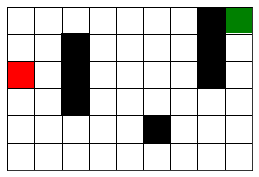

In [ ]:
map = get_maze()
fig = plt.figure(figsize=(5,3))
plot_circuit(fig,map,1)

### Constant Parameters

In [ ]:
num_trials = 30
num_episodes = 50
alpha = 0.1
gamma = 0.95
epsilon = 0.1
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]
start = [2,0]
goal  = [0,8]

In [ ]:
def step(state,action):
  new_state = [max(0,min(map.shape[0]-1,state[0]+action[0])),max(0,min(map.shape[1]-1,state[1]+action[1]))]
  reward = 0
  if map[new_state[0],new_state[1]] == OBSTACLE:
    return state,reward
  if new_state == goal:
    reward = 1
  return new_state,reward

def target_policy(Q,pos,actions,epsilon):
  nA = len(actions)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q[pos[0],pos[1],:])
  idx = np.where(Q[pos[0],pos[1],:] == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  return np.random.choice(range(nA),p=action_prob)

def get_action_idx(action):
  return np.where(np.sum(np.abs(actions-action),1) == 0)[0][0]

def TabularDynaQ(num_episodes,actions,alpha,gamma,epsilon,plan_steps):
  nA = len(actions)
  Q = np.zeros((map.shape[0],map.shape[1],nA))
  stats = []
  model = dict()
  traj = set()
  for episode in range(num_episodes):
    pos = start
    steps = 0
    rewards = 0
    while pos[0] != goal[0] or pos[1] != goal[1]:
      act_idx = target_policy(Q,pos,actions,epsilon)
      next_pos,reward = step(pos,actions[act_idx])
      # print("#################")
      # print(pos)
      # print(actions[act_idx])
      # print(next_pos)
      ## Update Q
      Q[pos[0],pos[1],act_idx] += alpha*(reward + gamma*max(Q[next_pos[0],next_pos[1],:]) - Q[pos[0],pos[1],act_idx])
      ## Update Model
      t = (pos[0],pos[1],act_idx)
      traj.add(t)
      model[(pos[0],pos[1],act_idx)] = (next_pos[0],next_pos[1],reward)
      ## Planning
      plan_c = 0
      while plan_c < plan_steps:
        t = list(traj)[np.random.choice(range(len(traj)))]
        s = [t[0],t[1]]
        a_idx = t[2]
        s_next,r = step(s,actions[a_idx])
        Q[s[0],s[1],a_idx] += alpha*(r + gamma*max(Q[s_next[0],s_next[1],:]) - Q[s[0],s[1],a_idx])
        plan_c += 1
      steps += 1
      pos = next_pos.copy()
    stats += [[episode+1,steps]]
  return Q,np.array(stats)

In [ ]:
plan_steps = [0,5,50]
# np.random.seed(0)
stats_avg = np.zeros((num_episodes,1+len(plan_steps)))
for pi,p in enumerate(plan_steps):
  np.random.seed(42)
  for i in tqdm(range(num_trials)):
    Q,stats = TabularDynaQ(num_episodes,hv_actions,alpha,gamma,epsilon,p)
    stats_avg[:,pi+1] += stats[:,1]/float(num_trials)
stats_avg[:,0] = stats[:,0]

100%|██████████| 30/30 [01:29<00:00,  2.98s/it]


Optimal Steps to Goal =  [17.73333333 16.86666667 16.13333333]


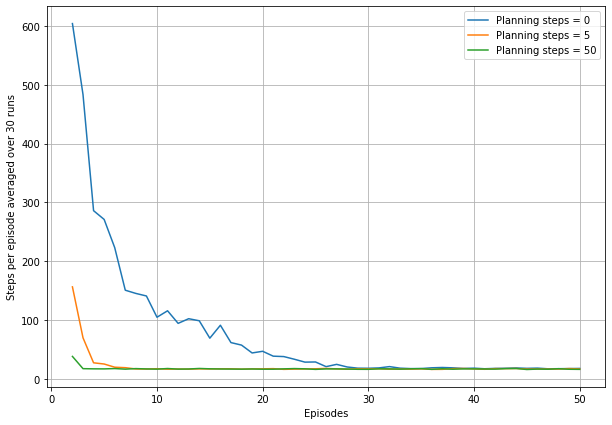

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
for i in range(1,stats_avg.shape[1]):
  ax.plot(stats_avg[1:,0],stats_avg[1:,i])
ax.grid(True)
ax.legend(['Planning steps = '+ str(p) for p in plan_steps])
ax.set_xlabel('Episodes')
ax.set_ylabel('Steps per episode averaged over ' + str(num_trials) + ' runs');
print('Optimal Steps to Goal = ', stats_avg[-1,1:])